In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2024-03-18 11:47:43--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py.1’

visualization.py.1  100%[===================>]  12.72K  --.-KB/s    in 0s      

2024-03-18 11:47:43 (104 MB/s) - ‘visualization.py.1’ saved [13023/13023]



# Download the dataset and train/test split

Load the dataset

In [20]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2024-03-18 11:47:49--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv.1’

lowdataset.csv.1    100%[===================>] 255.04K  --.-KB/s    in 0.005s  

2024-03-18 11:47:49 (48.0 MB/s) - ‘lowdataset.csv.1’ saved [261162/261162]

--2024-03-18 11:47:49--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|

In [21]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.59473178e+08
  1.00265909e+02 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.59522865e+08
  1.00276024e+02 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.59533231e+08
  1.00281822e+02 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.59453245e+08
  1.00262788e+02 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.59444187e+08
  1.00259509e+02 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.59458785e+08
  1.00264199e+02 2.00000000e+00]]


In [22]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,...,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,...,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,...,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,...,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,...,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,...,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [23]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 32)
Possible labels  [0 1 2]


In [24]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

#PCA Analysis

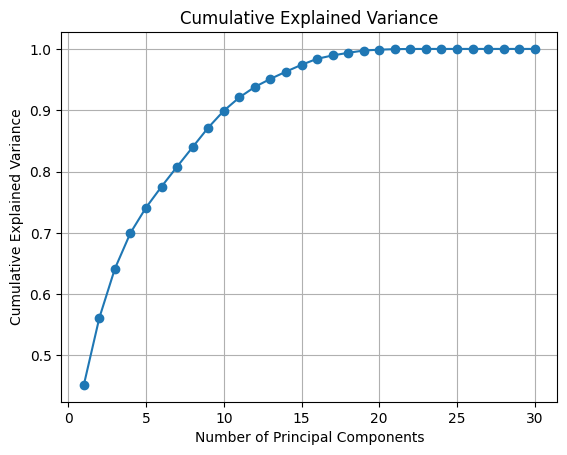

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -4.881740 -0.397795 -0.144481  0.000665  0.216587 -0.129800  0.024861   
1 -4.876827 -0.393100 -0.140719  0.002848  0.218767 -0.127143  0.019547   
2 -4.890663 -0.395902 -0.143938 -0.005094  0.245284 -0.136022  0.024361   
3 -4.907737 -0.395071 -0.131206 -0.014692  0.268965 -0.124720  0.029687   
4 -4.859870 -0.376164 -0.122017 -0.049976  0.210693 -0.156568  0.039330   

        PC8       PC9      PC10  ...      PC21      PC22      PC23      PC24  \
0 -0.231460  0.112418  0.343000  ...  0.009924  0.032998 -0.003828  0.001216   
1 -0.234002  0.109568  0.334747  ...  0.009855  0.031718 -0.004083  0.001539   
2 -0.233091  0.117804  0.335475  ...  0.011380  0.026984 -0.004083  0.001437   
3 -0.238461  0.118216  0.324296  ...  0.010873  0.024584 -0.003974  0.001394   
4 -0.222458  0.138637  0.323179  ...  0.013409  0.033303 -0.004150  0.001365   

       PC25      PC26      PC27      PC28      PC29          PC30  


In [25]:
## Standardize the data
full_df_no_labels = full_df.drop(columns=["label"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df_no_labels)

# Initialize PCA and specify the number of components you want to keep
num_components = 30  # You can choose a different number based on your analysis
pca = PCA(n_components=num_components)
# Fit PCA to the scaled data
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i}' for i in range(1, num_components + 1)])

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plotting the explained variance
plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)  # Add grid
plt.show()

# Display the DataFrame with the principal components
print(pca_df.head())


Top features contributing to PC1:
       Feature   Loading
30  task-clock  0.255612
15   cpu-clock  0.255612
29  ref-cycles  0.255592
11  bus-cycles  0.255590
16      cycles  0.255584


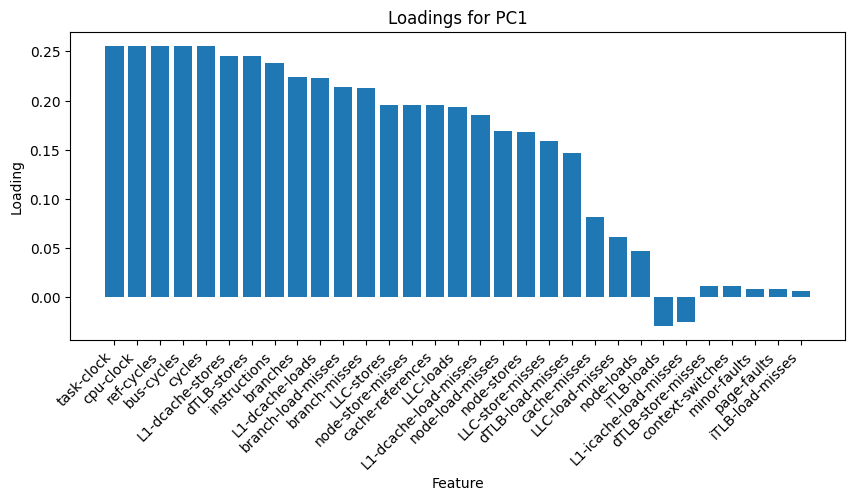


Top features contributing to PC2:
                  Feature   Loading
17       dTLB-load-misses -0.346076
5               LLC-loads -0.341929
13       cache-references -0.338893
0   L1-dcache-load-misses -0.324422
7              LLC-stores -0.319349


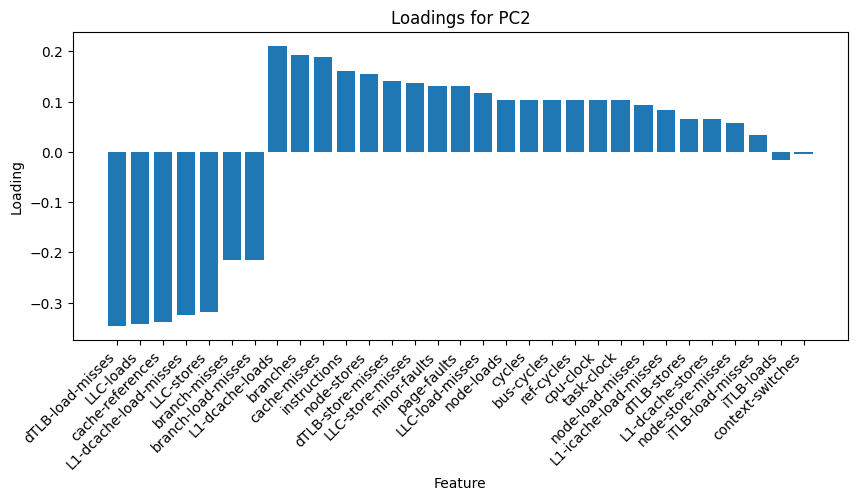


Top features contributing to PC3:
                  Feature   Loading
23           minor-faults  0.505888
28            page-faults  0.505888
3   L1-icache-load-misses  0.382112
25             node-loads  0.215447
12           cache-misses  0.203669


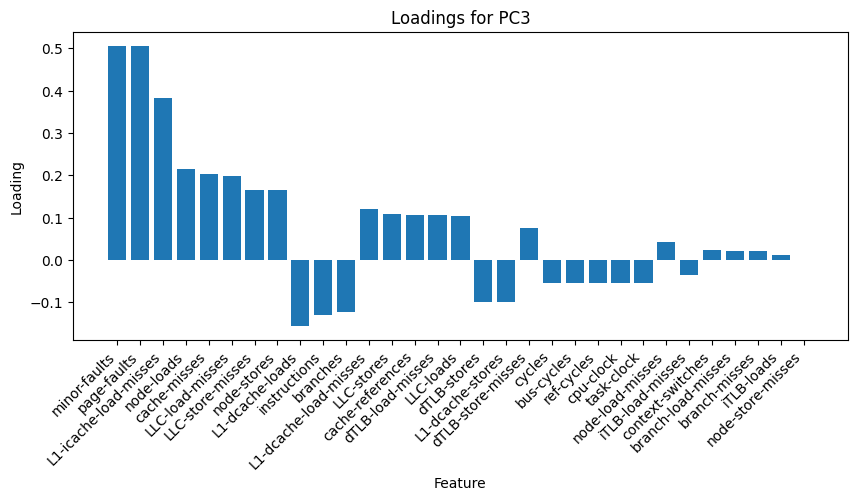


Top features contributing to PC4:
            Feature   Loading
4   LLC-load-misses -0.510292
25       node-loads -0.427911
12     cache-misses -0.424502
28      page-faults  0.334294
23     minor-faults  0.334294


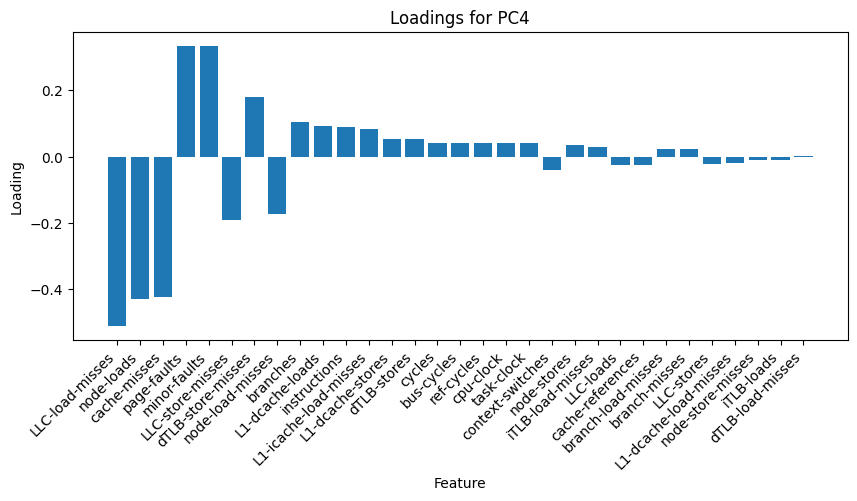


Top features contributing to PC5:
               Feature   Loading
18   dTLB-store-misses  0.590117
26   node-store-misses -0.269421
25          node-loads  0.223903
9        branch-misses -0.203194
8   branch-load-misses -0.202972


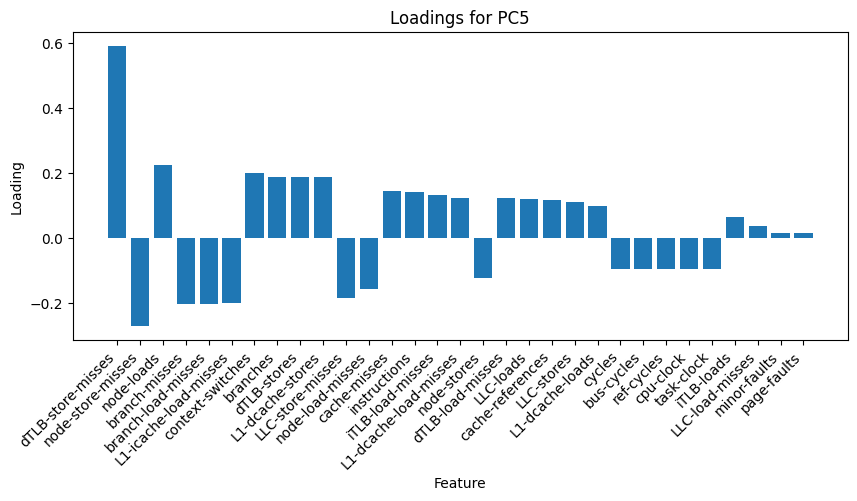


Top features contributing to PC6:
                  Feature   Loading
14       context-switches  0.652805
3   L1-icache-load-misses  0.364073
6        LLC-store-misses  0.343390
25             node-loads -0.310576
12           cache-misses -0.189311


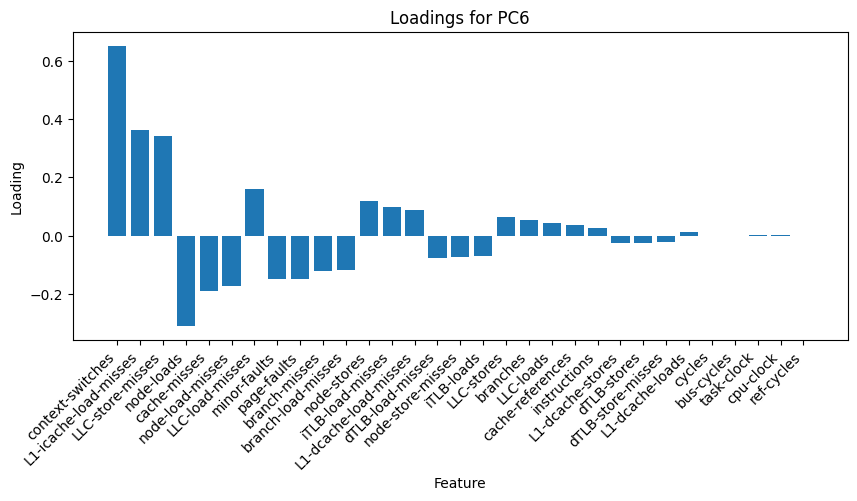


Top features contributing to PC7:
              Feature   Loading
20   iTLB-load-misses  0.875222
18  dTLB-store-misses -0.331510
6    LLC-store-misses -0.156545
14   context-switches  0.150678
25         node-loads  0.128335


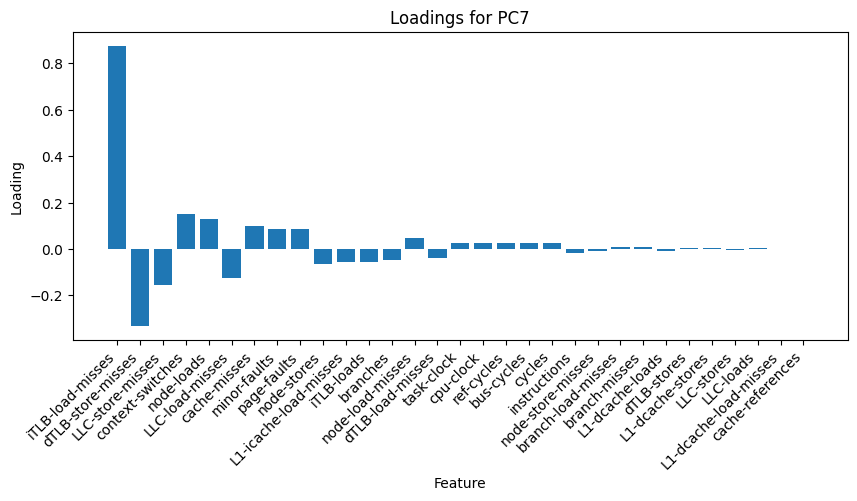


Top features contributing to PC8:
              Feature   Loading
21         iTLB-loads  0.910999
14   context-switches  0.300078
18  dTLB-store-misses -0.139696
20   iTLB-load-misses -0.112270
4     LLC-load-misses -0.103896


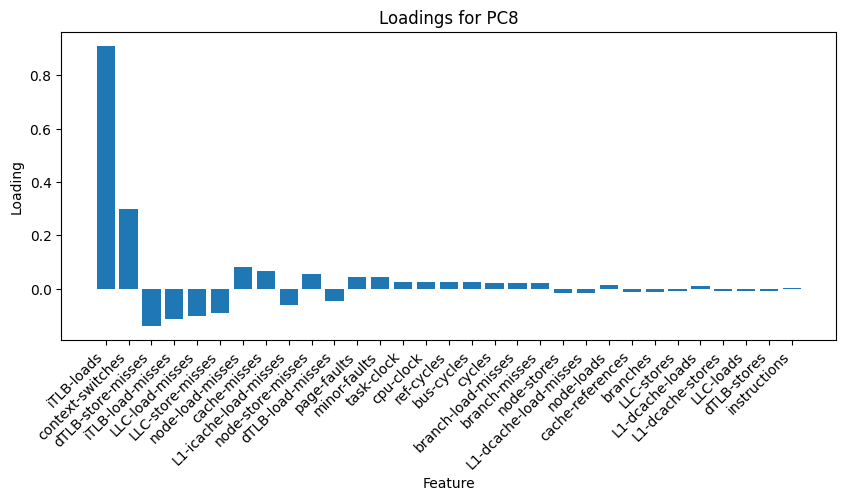


Top features contributing to PC9:
             Feature   Loading
14  context-switches  0.560583
21        iTLB-loads -0.387898
20  iTLB-load-misses -0.385667
6   LLC-store-misses -0.345337
4    LLC-load-misses -0.307949


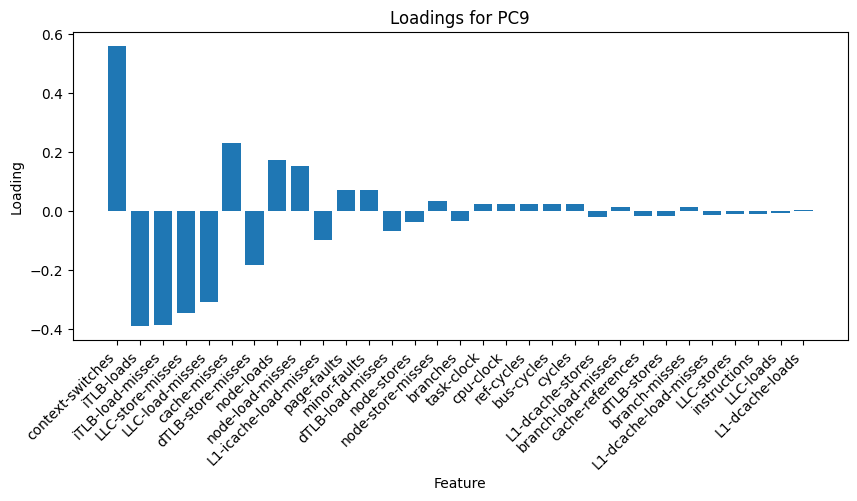


Top features contributing to PC10:
                  Feature   Loading
3   L1-icache-load-misses -0.545180
27            node-stores -0.420652
4         LLC-load-misses  0.390352
23           minor-faults  0.271177
28            page-faults  0.271177


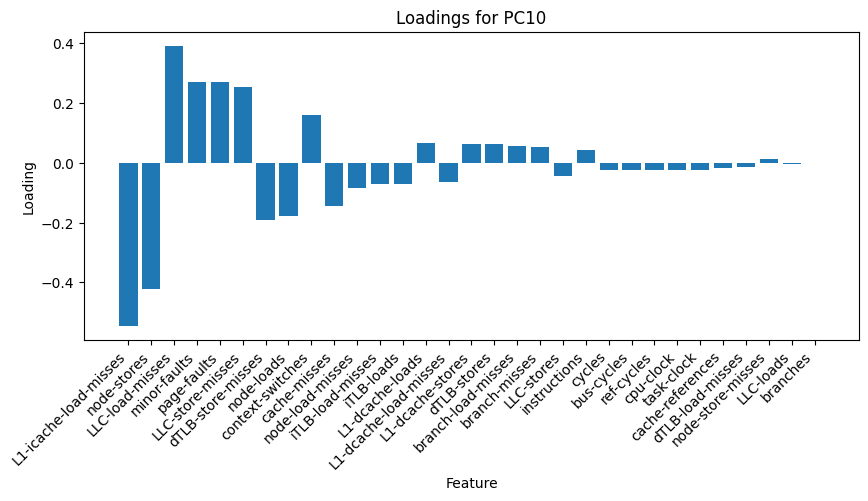


Top features contributing to PC11:
              Feature   Loading
18  dTLB-store-misses  0.514520
24   node-load-misses  0.403964
26  node-store-misses  0.315918
25         node-loads -0.229390
14   context-switches  0.222398


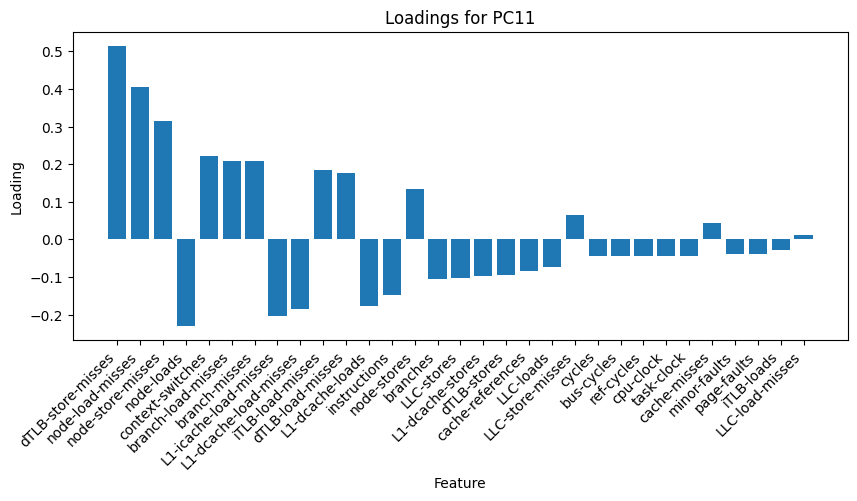


Top features contributing to PC12:
               Feature   Loading
24    node-load-misses  0.583682
25          node-loads -0.496044
9        branch-misses -0.329335
8   branch-load-misses -0.329285
12        cache-misses  0.235363


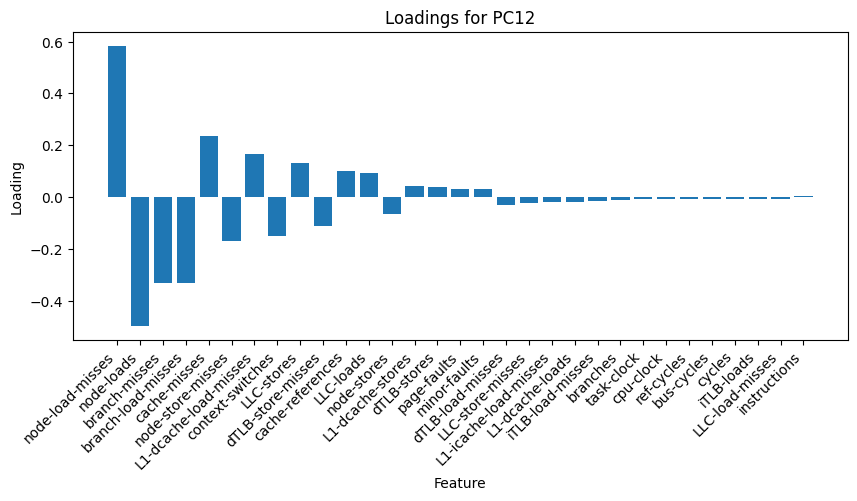


Top features contributing to PC13:
                  Feature   Loading
27            node-stores  0.552132
12           cache-misses  0.428744
24       node-load-misses -0.389386
25             node-loads -0.332266
3   L1-icache-load-misses -0.273759


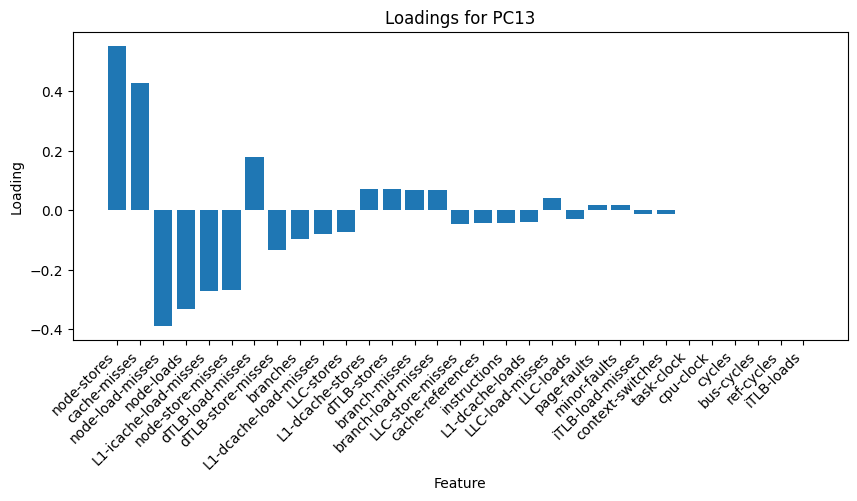


Top features contributing to PC14:
                  Feature   Loading
26      node-store-misses -0.681587
12           cache-misses -0.303840
17       dTLB-load-misses -0.280451
24       node-load-misses  0.252811
3   L1-icache-load-misses -0.199483


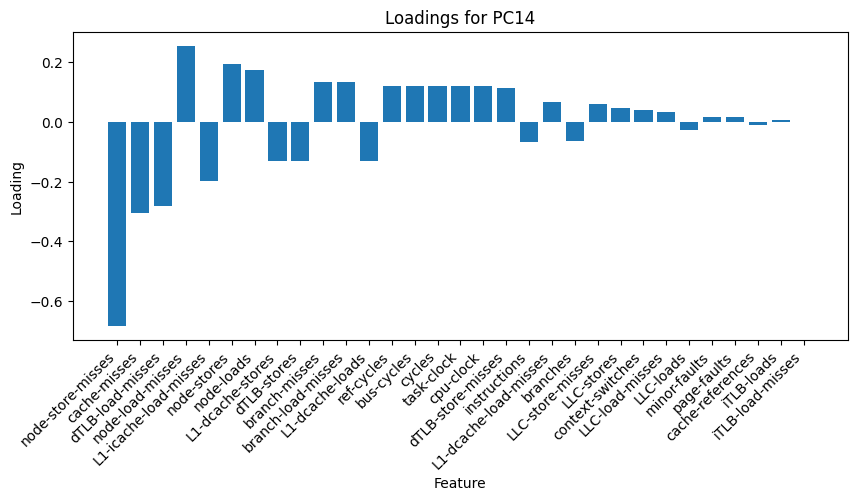


Top features contributing to PC15:
                  Feature   Loading
17       dTLB-load-misses -0.444927
27            node-stores  0.440990
26      node-store-misses  0.426027
3   L1-icache-load-misses -0.369791
0   L1-dcache-load-misses  0.219688


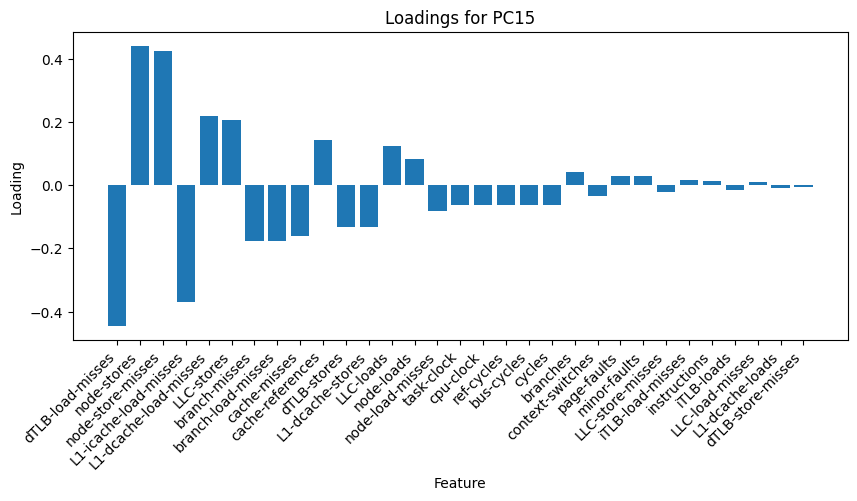


Top features contributing to PC16:
              Feature   Loading
17   dTLB-load-misses  0.428753
12       cache-misses -0.399841
27        node-stores  0.373436
24   node-load-misses  0.298273
18  dTLB-store-misses -0.258593


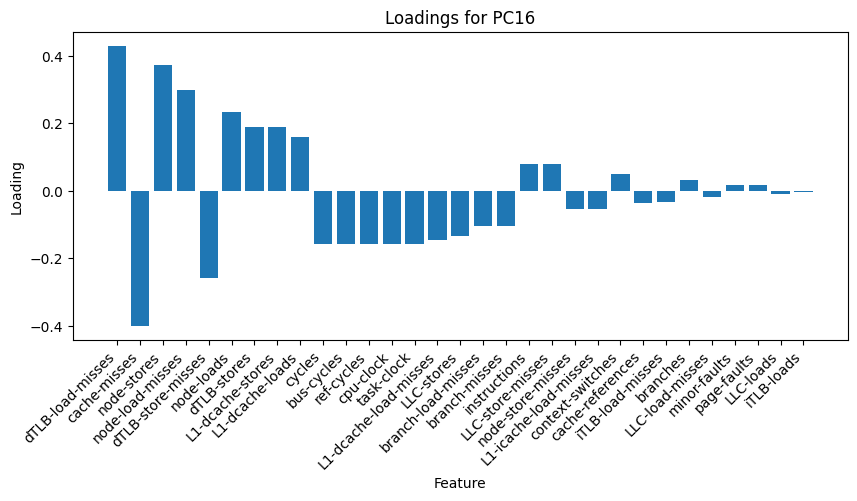


Top features contributing to PC17:
               Feature   Loading
17    dTLB-load-misses  0.437013
8   branch-load-misses -0.341126
9        branch-misses -0.340490
1      L1-dcache-loads -0.231712
29          ref-cycles  0.214869


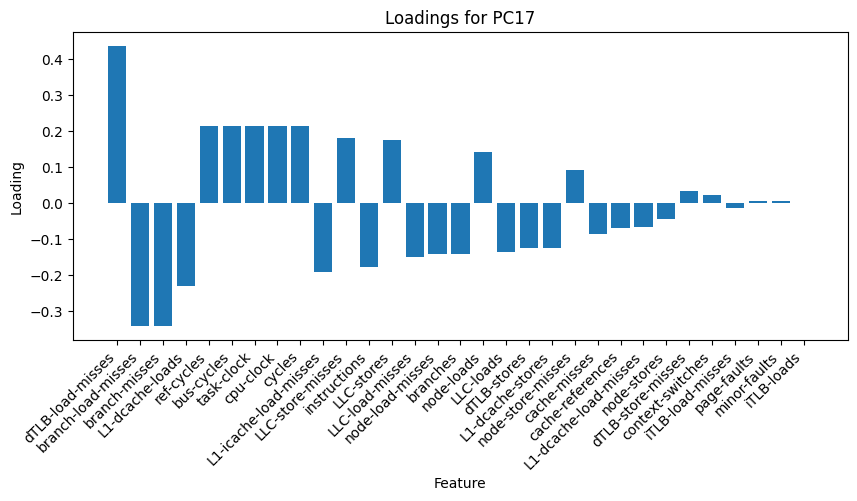


Top features contributing to PC18:
                  Feature   Loading
6        LLC-store-misses  0.681026
4         LLC-load-misses -0.589221
12           cache-misses  0.243999
3   L1-icache-load-misses -0.126246
29             ref-cycles -0.099173


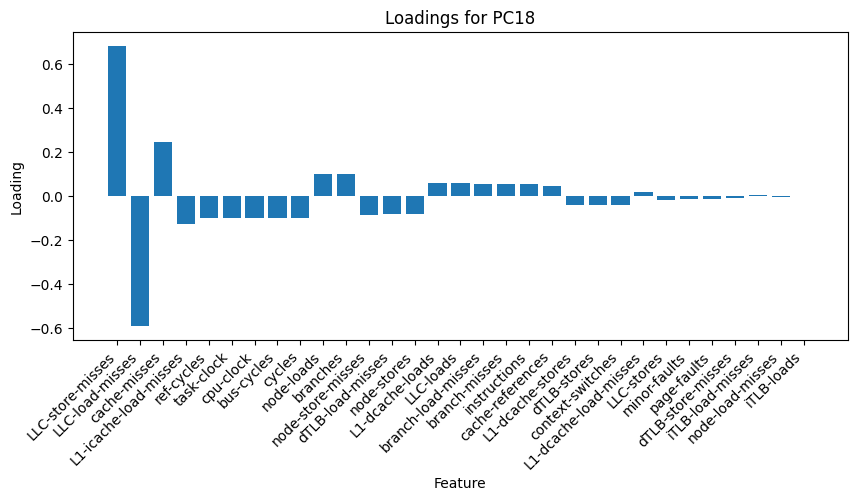


Top features contributing to PC19:
             Feature   Loading
10          branches -0.567961
19       dTLB-stores  0.483482
2   L1-dcache-stores  0.482046
17  dTLB-load-misses -0.271420
1    L1-dcache-loads -0.229523


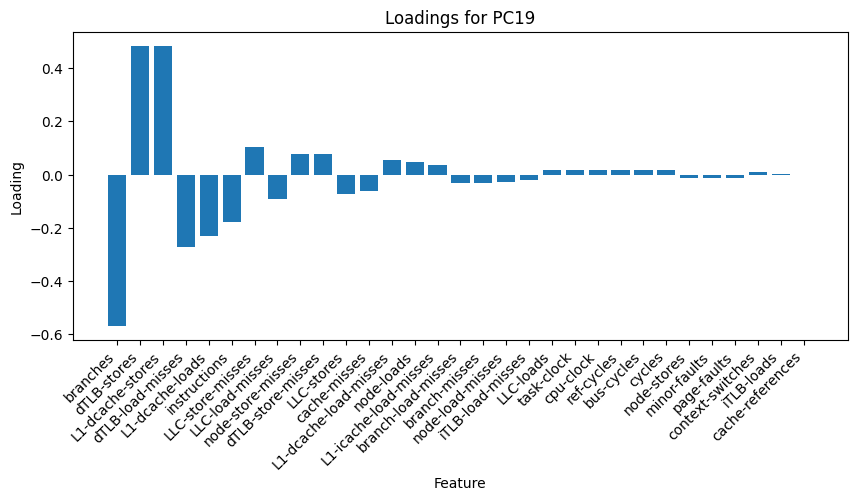


Top features contributing to PC20:
                  Feature   Loading
0   L1-dcache-load-misses  0.705544
7              LLC-stores -0.425000
1         L1-dcache-loads  0.312694
10               branches -0.303527
13       cache-references -0.198802


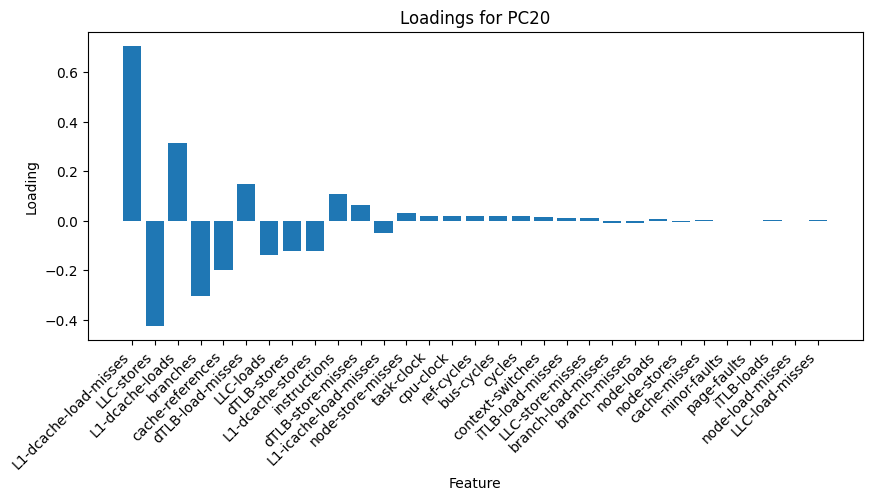


Top features contributing to PC21:
                  Feature   Loading
7              LLC-stores  0.619904
5               LLC-loads -0.605617
13       cache-references -0.332839
0   L1-dcache-load-misses  0.200558
22           instructions  0.154469


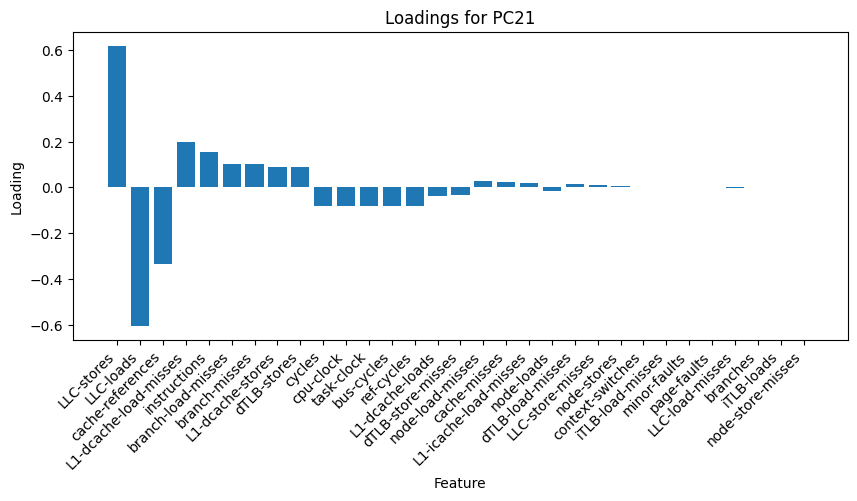


Top features contributing to PC22:
                  Feature   Loading
1         L1-dcache-loads -0.692383
10               branches  0.509174
0   L1-dcache-load-misses  0.324766
7              LLC-stores -0.317754
19            dTLB-stores  0.112299


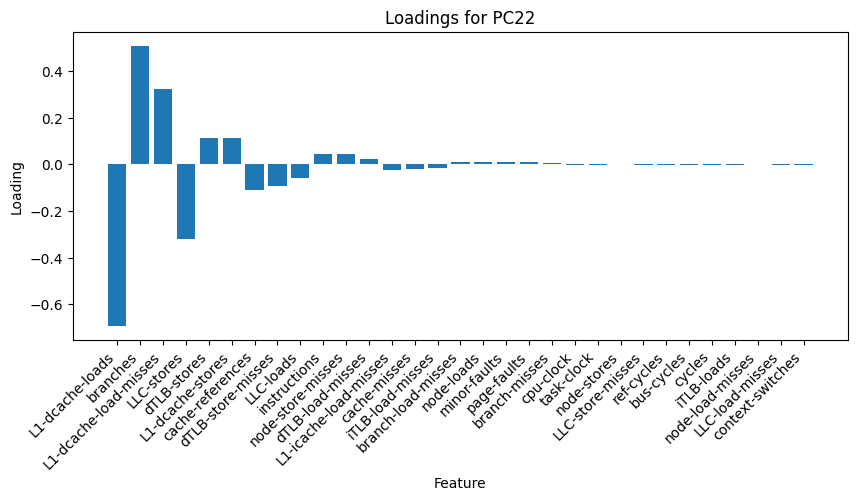


Top features contributing to PC23:
               Feature   Loading
22        instructions  0.806567
10            branches -0.317461
1      L1-dcache-loads -0.290634
9        branch-misses -0.248396
8   branch-load-misses  0.216003


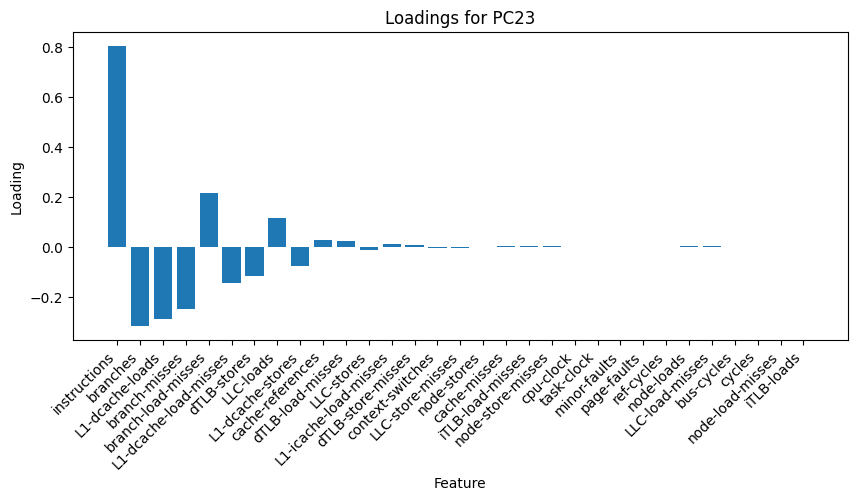


Top features contributing to PC24:
               Feature   Loading
8   branch-load-misses  0.672975
9        branch-misses -0.662103
22        instructions -0.282084
10            branches  0.109339
1      L1-dcache-loads  0.103352


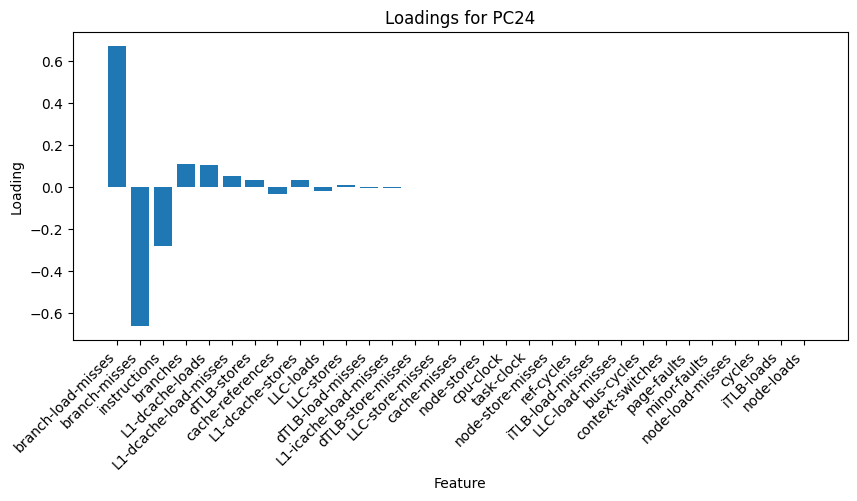


Top features contributing to PC25:
             Feature   Loading
13  cache-references  0.775777
5          LLC-loads -0.599167
7         LLC-stores -0.172303
19       dTLB-stores -0.063609
2   L1-dcache-stores  0.054779


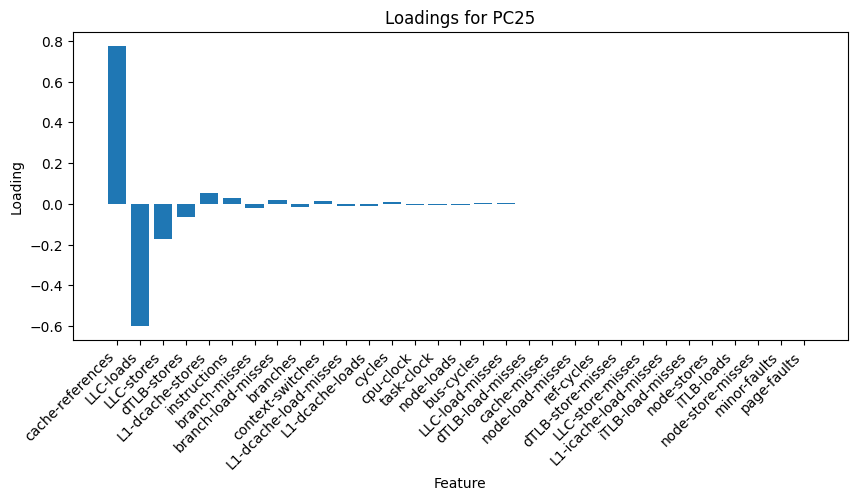


Top features contributing to PC26:
             Feature   Loading
2   L1-dcache-stores  0.707817
19       dTLB-stores -0.700867
13  cache-references -0.065859
5          LLC-loads  0.047754
22      instructions -0.024483


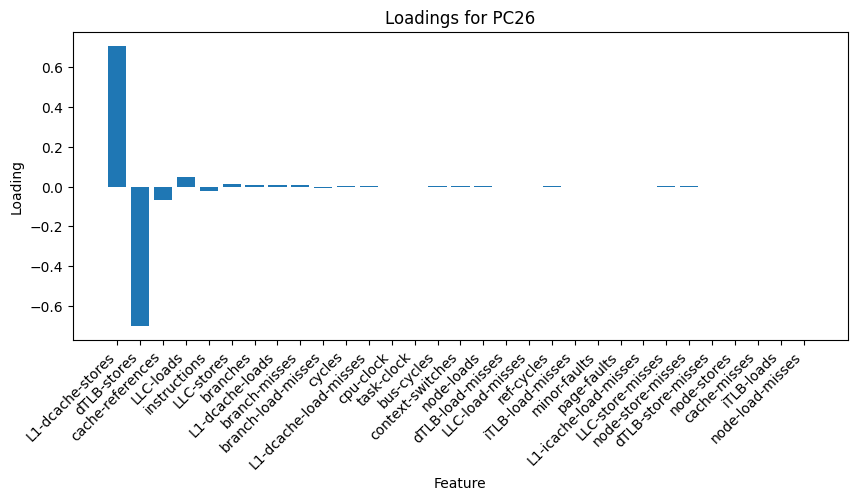


Top features contributing to PC27:
       Feature   Loading
16      cycles  0.615089
15   cpu-clock -0.512849
30  task-clock -0.512370
11  bus-cycles  0.282170
29  ref-cycles  0.127640


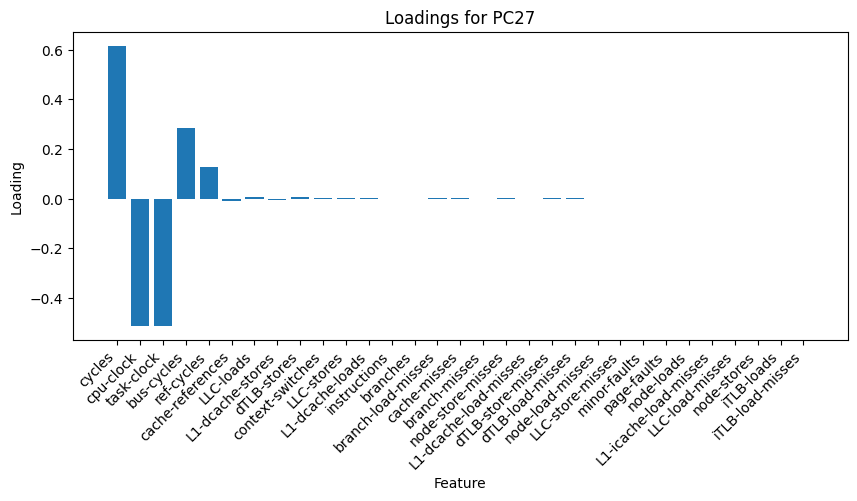


Top features contributing to PC28:
       Feature   Loading
29  ref-cycles -0.715774
16      cycles  0.588588
11  bus-cycles -0.258485
15   cpu-clock  0.193886
30  task-clock  0.191889


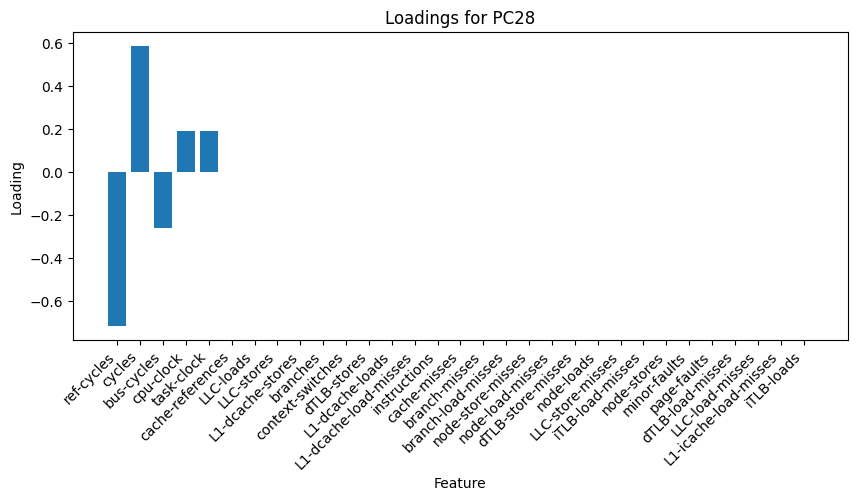


Top features contributing to PC29:
       Feature   Loading
11  bus-cycles  0.808385
29  ref-cycles -0.520889
16      cycles -0.274005
15   cpu-clock -0.009842
30  task-clock -0.003647


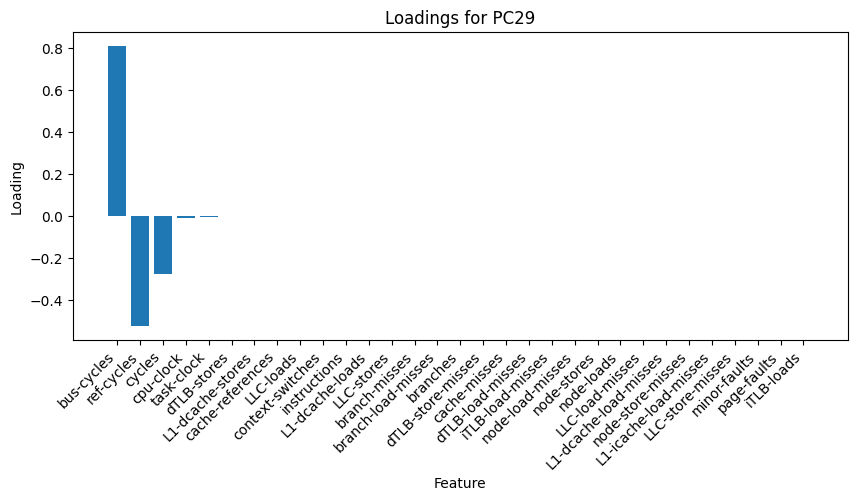


Top features contributing to PC30:
       Feature   Loading
30  task-clock -0.707575
15   cpu-clock  0.706623
11  bus-cycles  0.004002
16      cycles -0.001823
29  ref-cycles -0.001228


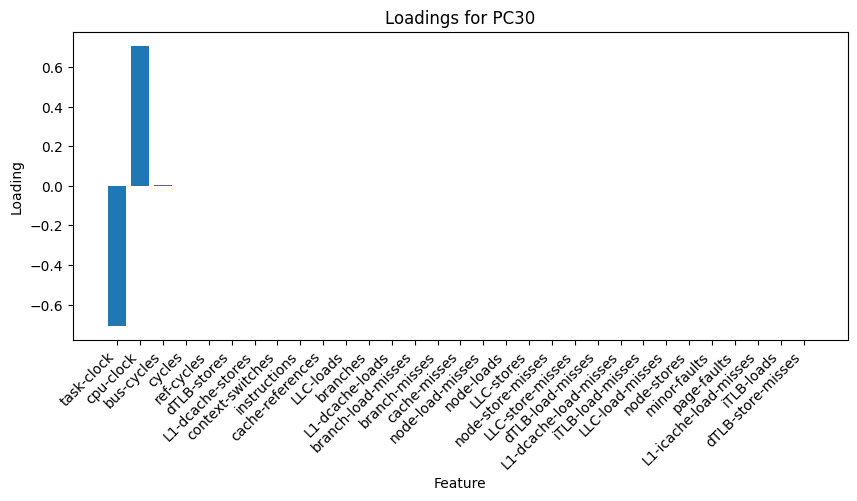

In [26]:
# Access the loadings (coefficients) of each original feature for the first few principal components
for i in range(1, num_components + 1):
    loadings_i = pca.components_[i-1]
    component_name = f'PC{i}'
    loading_df = pd.DataFrame({'Feature': full_df_no_labels.columns, 'Loading': loadings_i})
    loading_df = loading_df.sort_values(by='Loading', key=abs, ascending=False)

    # Display the top features contributing to each component
    print(f"\nTop features contributing to {component_name}:")
    print(loading_df.head())

    # Optionally, you can visualize the loadings
    plt.figure(figsize=(10, 4))
    plt.bar(loading_df['Feature'], loading_df['Loading'])
    plt.title(f'Loadings for {component_name}')
    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.xticks(rotation=45, ha='right')
    plt.show()


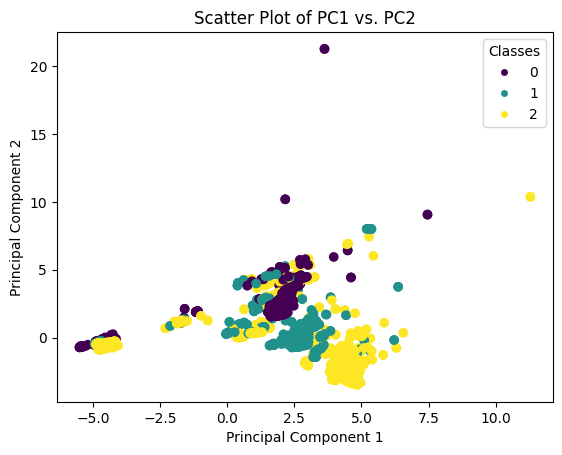

In [27]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC1 vs. PC2
scatter_plot = plt.scatter(pca_combined['PC1'], pca_combined['PC2'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 vs. PC2')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

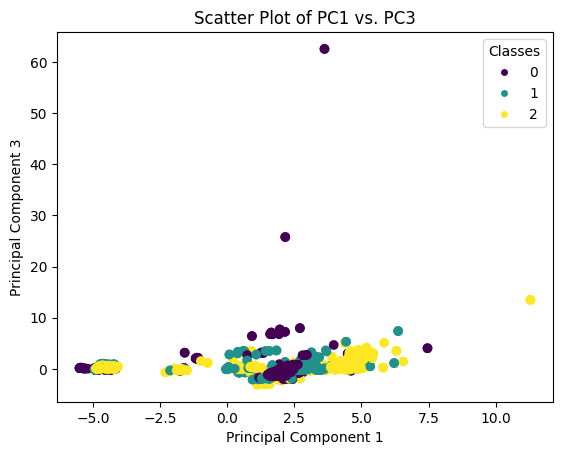

In [28]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC1 vs. PC3
scatter_plot = plt.scatter(pca_combined['PC1'], pca_combined['PC3'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatter Plot of PC1 vs. PC3')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

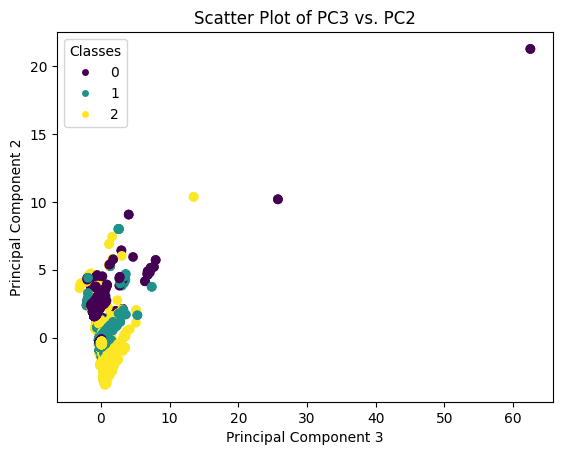

In [29]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC3 vs. PC2
scatter_plot = plt.scatter(pca_combined['PC3'], pca_combined['PC2'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC3 vs. PC2')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

In [30]:
# Pair Plot
#sns.pairplot(pca_combined, hue='label', diag_kind='kde')
#plt.suptitle('Pair Plot of Principal Components')
#plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'target' is the column with class labels
class_labels = full_df['label']

# Combine principal components with class labels
pca_combined = pd.concat([pca_df, class_labels], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,  # Adjust the test size based on your preference
    random_state=42
)

# Initialize and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print('The Classification report of SVM with all clock cycle features')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


The Classification report of SVM with all clock cycle features
Accuracy: 0.8180257510729614
Confusion Matrix:
[[371   2   1]
 [ 90 267  19]
 [ 91   9 315]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       374
           1       0.96      0.71      0.82       376
           2       0.94      0.76      0.84       415

    accuracy                           0.82      1165
   macro avg       0.86      0.82      0.82      1165
weighted avg       0.86      0.82      0.82      1165



In [32]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Initialize and train a Logistic Regression classifier
logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)
logreg_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluate the performance of the Logistic Regression classifier
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_rep_logreg = classification_report(y_test, y_pred_logreg)

print('The Classification report of Logistic Regression with all clock cycle features')
print(f'Accuracy (Logistic Regression): {accuracy_logreg}')
print('Confusion Matrix (Logistic Regression):')
print(conf_matrix_logreg)
print('Classification Report (Logistic Regression):')
print(classification_rep_logreg)


The Classification report of Logistic Regression with all clock cycle features
Accuracy (Logistic Regression): 0.8163090128755365
Confusion Matrix (Logistic Regression):
[[362   5   7]
 [ 88 270  18]
 [ 24  72 319]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       374
           1       0.78      0.72      0.75       376
           2       0.93      0.77      0.84       415

    accuracy                           0.82      1165
   macro avg       0.82      0.82      0.81      1165
weighted avg       0.83      0.82      0.81      1165



In [33]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'target' is the column with class labels
class_labels = full_df['label']

# Combine principal components with class labels
pca_combined = pd.concat([pca_df, class_labels], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,  # Adjust the test size based on your preference
    random_state=42
)

# Initialize and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print('The Classification report of SVM with all clock cycle features removed')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


The Classification report of SVM with all clock cycle features removed
Accuracy: 0.8180257510729614
Confusion Matrix:
[[371   2   1]
 [ 90 267  19]
 [ 91   9 315]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       374
           1       0.96      0.71      0.82       376
           2       0.94      0.76      0.84       415

    accuracy                           0.82      1165
   macro avg       0.86      0.82      0.82      1165
weighted avg       0.86      0.82      0.82      1165



In [34]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print('The Classification report of Decision Tree with all clock cycle features')
print(f'Accuracy (Decision Tree): {accuracy_dt}')
print('Confusion Matrix (Decision Tree):')
print(conf_matrix_dt)
print('Classification Report (Decision Tree):')
print(classification_rep_dt)

The Classification report of Decision Tree with all clock cycle features
Accuracy (Decision Tree): 0.9871244635193133
Confusion Matrix (Decision Tree):
[[367   3   4]
 [  1 369   6]
 [  1   0 414]]
Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       374
           1       0.99      0.98      0.99       376
           2       0.98      1.00      0.99       415

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



In [35]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print('The Classification report of Random Forest with all clock cycle features')
print(f'Accuracy (Random Forest): {accuracy_rf}')
print('Confusion Matrix (Random Forest):')
print(conf_matrix_rf)
print('Classification Report (Random Forest):')
print(classification_rep_rf)

The Classification report of Random Forest with all clock cycle features
Accuracy (Random Forest): 0.9939914163090129
Confusion Matrix (Random Forest):
[[374   0   0]
 [  0 376   0]
 [  1   6 408]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       0.98      1.00      0.99       376
           2       1.00      0.98      0.99       415

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



In [36]:
from sklearn.neural_network import MLPClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Neural Network Classifier
nn_classifier = MLPClassifier(max_iter=1000, random_state=42)
nn_classifier.fit(X_train, y_train)
y_pred_nn = nn_classifier.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
classification_rep_nn = classification_report(y_test, y_pred_nn)

print('The Classification report of Neural Network with all clock cycle features')
print(f'Accuracy (Neural Network): {accuracy_nn}')
print('Confusion Matrix (Neural Network):')
print(conf_matrix_nn)
print('Classification Report (Neural Network):')
print(classification_rep_nn)

The Classification report of Neural Network with all clock cycle features
Accuracy (Neural Network): 0.975107296137339
Confusion Matrix (Neural Network):
[[365   1   8]
 [  3 365   8]
 [  3   6 406]]
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       374
           1       0.98      0.97      0.98       376
           2       0.96      0.98      0.97       415

    accuracy                           0.98      1165
   macro avg       0.98      0.97      0.98      1165
weighted avg       0.98      0.98      0.98      1165

